In [17]:
#GENERAL
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance
#PATH PROCESS
#IMAGE PROCESS
import cv2
#MACHINE LEARNING
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.manifold import TSNE
from functools import partial
from sklearn.cluster import AgglomerativeClustering
from sklearn_extra.cluster import KMedoids


Functions used later in the code

In [ ]:
def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

def count_wcss_scores(X, k_max):
    #  WCSS = within-cluster sum of squares
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(X)
        wcss = kmeans.score(X) * -1 # score returns -WCSS
        scores.append(wcss)
    return scores

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

Now we have transformed our photos into three independent datasets. Each of them represents fetaures obtained in a different way:
* using VGG16 Model
* using AutoEncoder
* using Noise Removing Model

## 1. Let's try KMeans model for images processed with AutoEncoder

In [126]:
df1 = np.load('../data/After_Auto_Encoder_Test.npy')
df2 = np.load('../data/After_Auto_Encoder_Train.npy')
# Sample function to get random rows from a numpy array
def sample_array(arr, n, random_state=None):
    np.random.seed(random_state)
    indices = np.random.choice(arr.shape[0], n, replace=False)
    return arr[indices]

# Get 200 random rows from df1
df1_sample = sample_array(df1, 2000, random_state=42)

# Get 800 random rows from df2
df2_sample = sample_array(df2, 8000, random_state=42)

# Concatenate the sampled arrays
df = np.vstack([df1_sample, df2_sample])

df = df.reshape(10000, 28 * 28)

images = df

print(df.shape)

(10000, 784)


In [127]:
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [128]:
# Performing PCA to retain 90% of the variance
pca = PCA(random_state=22)
pca.fit(df)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

In [129]:
n_components_90

5

In [130]:
# Performing PCA with the determined number of components
pca = PCA(n_components=5, random_state=22)
pca.fit(df)
x = pca.transform(df)

In [131]:
# Converting the transformed features to a DataFrame
features_df = pd.DataFrame(x)

# Adding prefixes to feature column names to avoid confusion with existing columns
features_df.columns = [f'feature_{i}' for i in range(features_df.shape[1])]


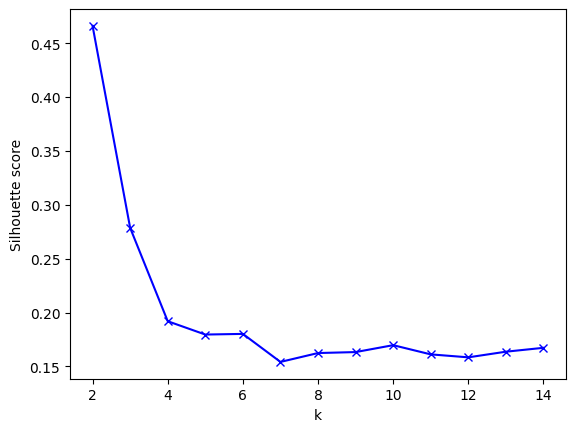

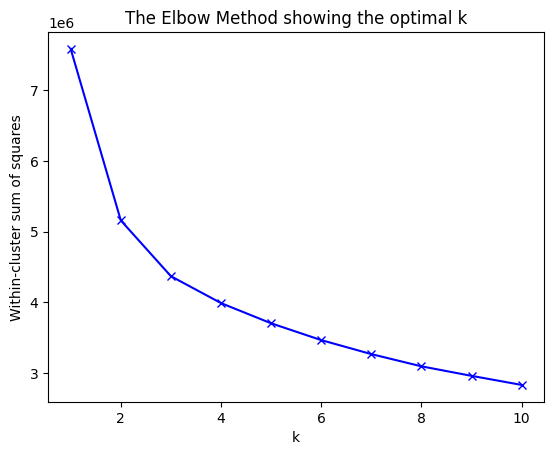

In [19]:
X = features_df

X = X.iloc[:10000, :]

cluster_num_seq = range(2,15)
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

wcss_vec = count_wcss_scores(X, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

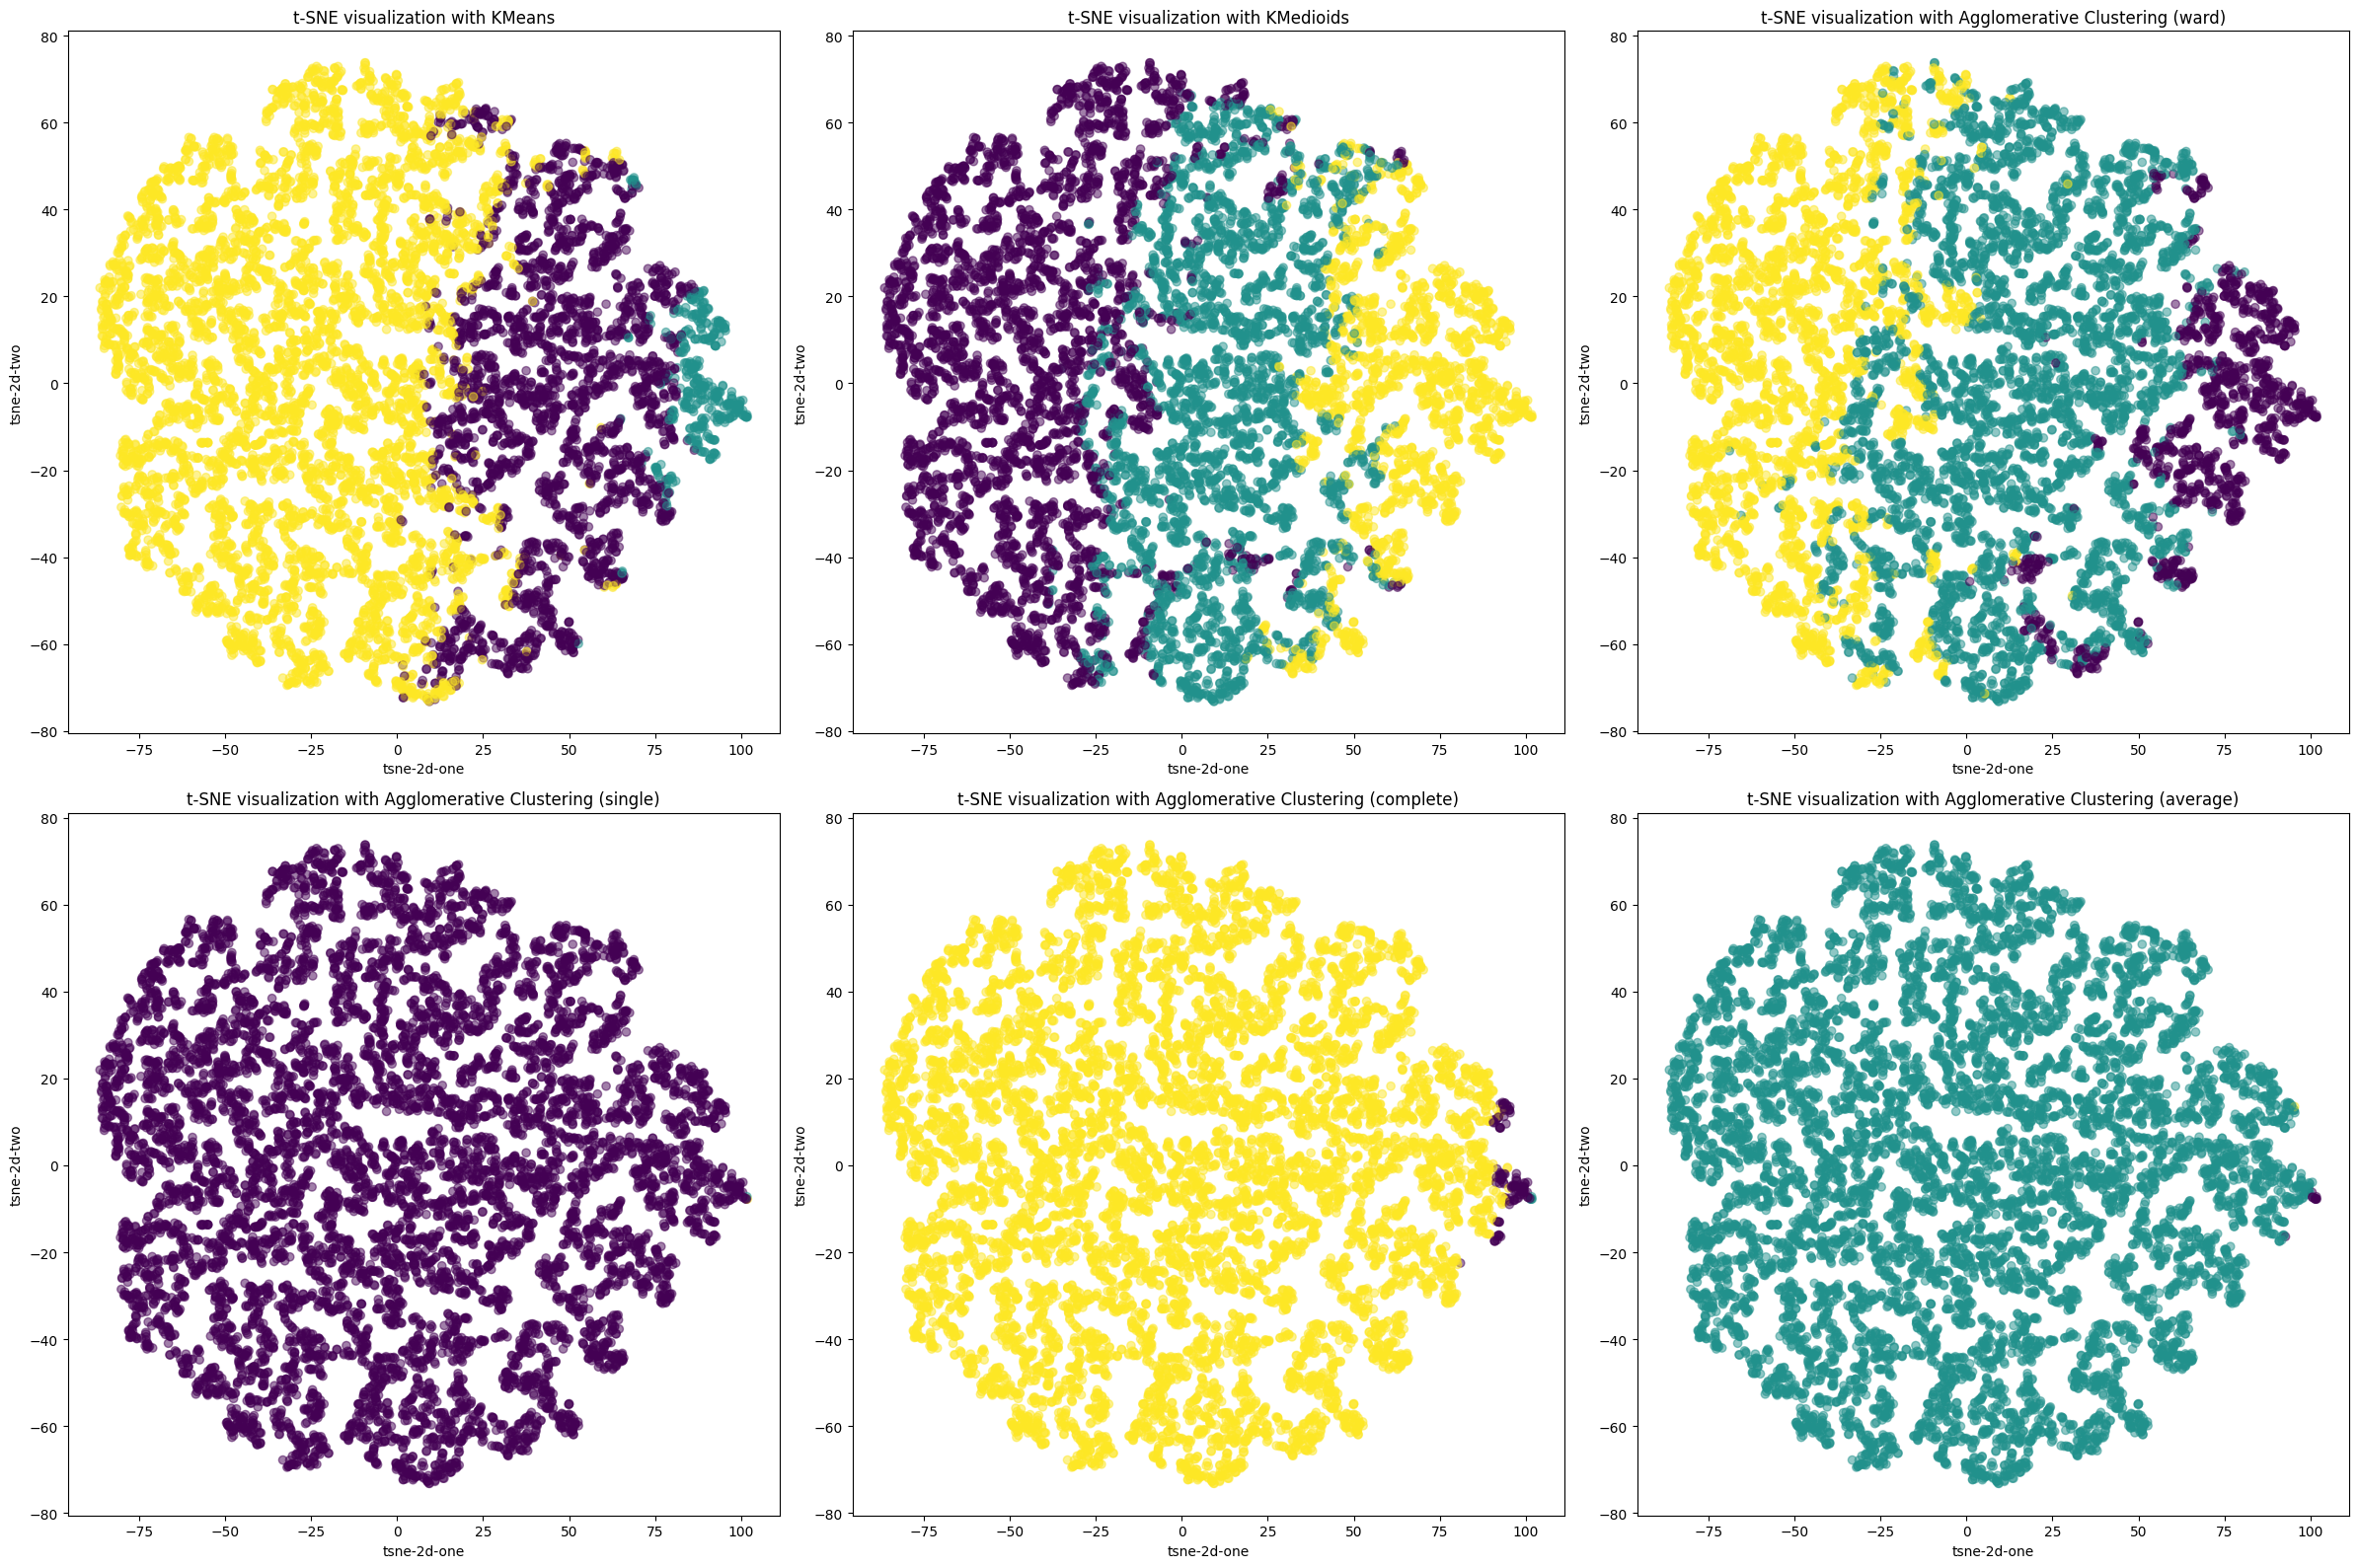

In [132]:
df = features_df

# Apply t-SNE
tsne = TSNE(n_components=2, learning_rate=200)
z = tsne.fit_transform(df)

# Add t-SNE results to the DataFrame for visualization
tsne_2d_one = z[:,0]
tsne_2d_two = z[:,1]

models = {
    'KMeans': KMeans(n_clusters=3),
    'KMedioids': KMedoids(n_clusters=3),
    'Agglomerative Clustering (ward)': AgglomerativeClustering(linkage='ward', n_clusters=3),
    'Agglomerative Clustering (single)': AgglomerativeClustering(linkage='single', n_clusters=3),
    'Agglomerative Clustering (complete)': AgglomerativeClustering(linkage='complete', n_clusters=3),
    'Agglomerative Clustering (average)': AgglomerativeClustering(linkage='average', n_clusters=3)
}

# Przeprowadzanie klasteryzacji i tworzenie wykresów
fig, axs = plt.subplots(2, 3, figsize=(24, 16))

for ax, (name, model) in zip(axs.flatten(), models.items()):
    labels = model.fit_predict(df)
    ax.scatter(
        x=tsne_2d_one, 
        y=tsne_2d_two,
        alpha=0.5,
        c=labels
    )
    ax.set_title(f't-SNE visualization with {name}')
    ax.set_xlabel('tsne-2d-one')
    ax.set_ylabel('tsne-2d-two')

plt.tight_layout()
plt.show()

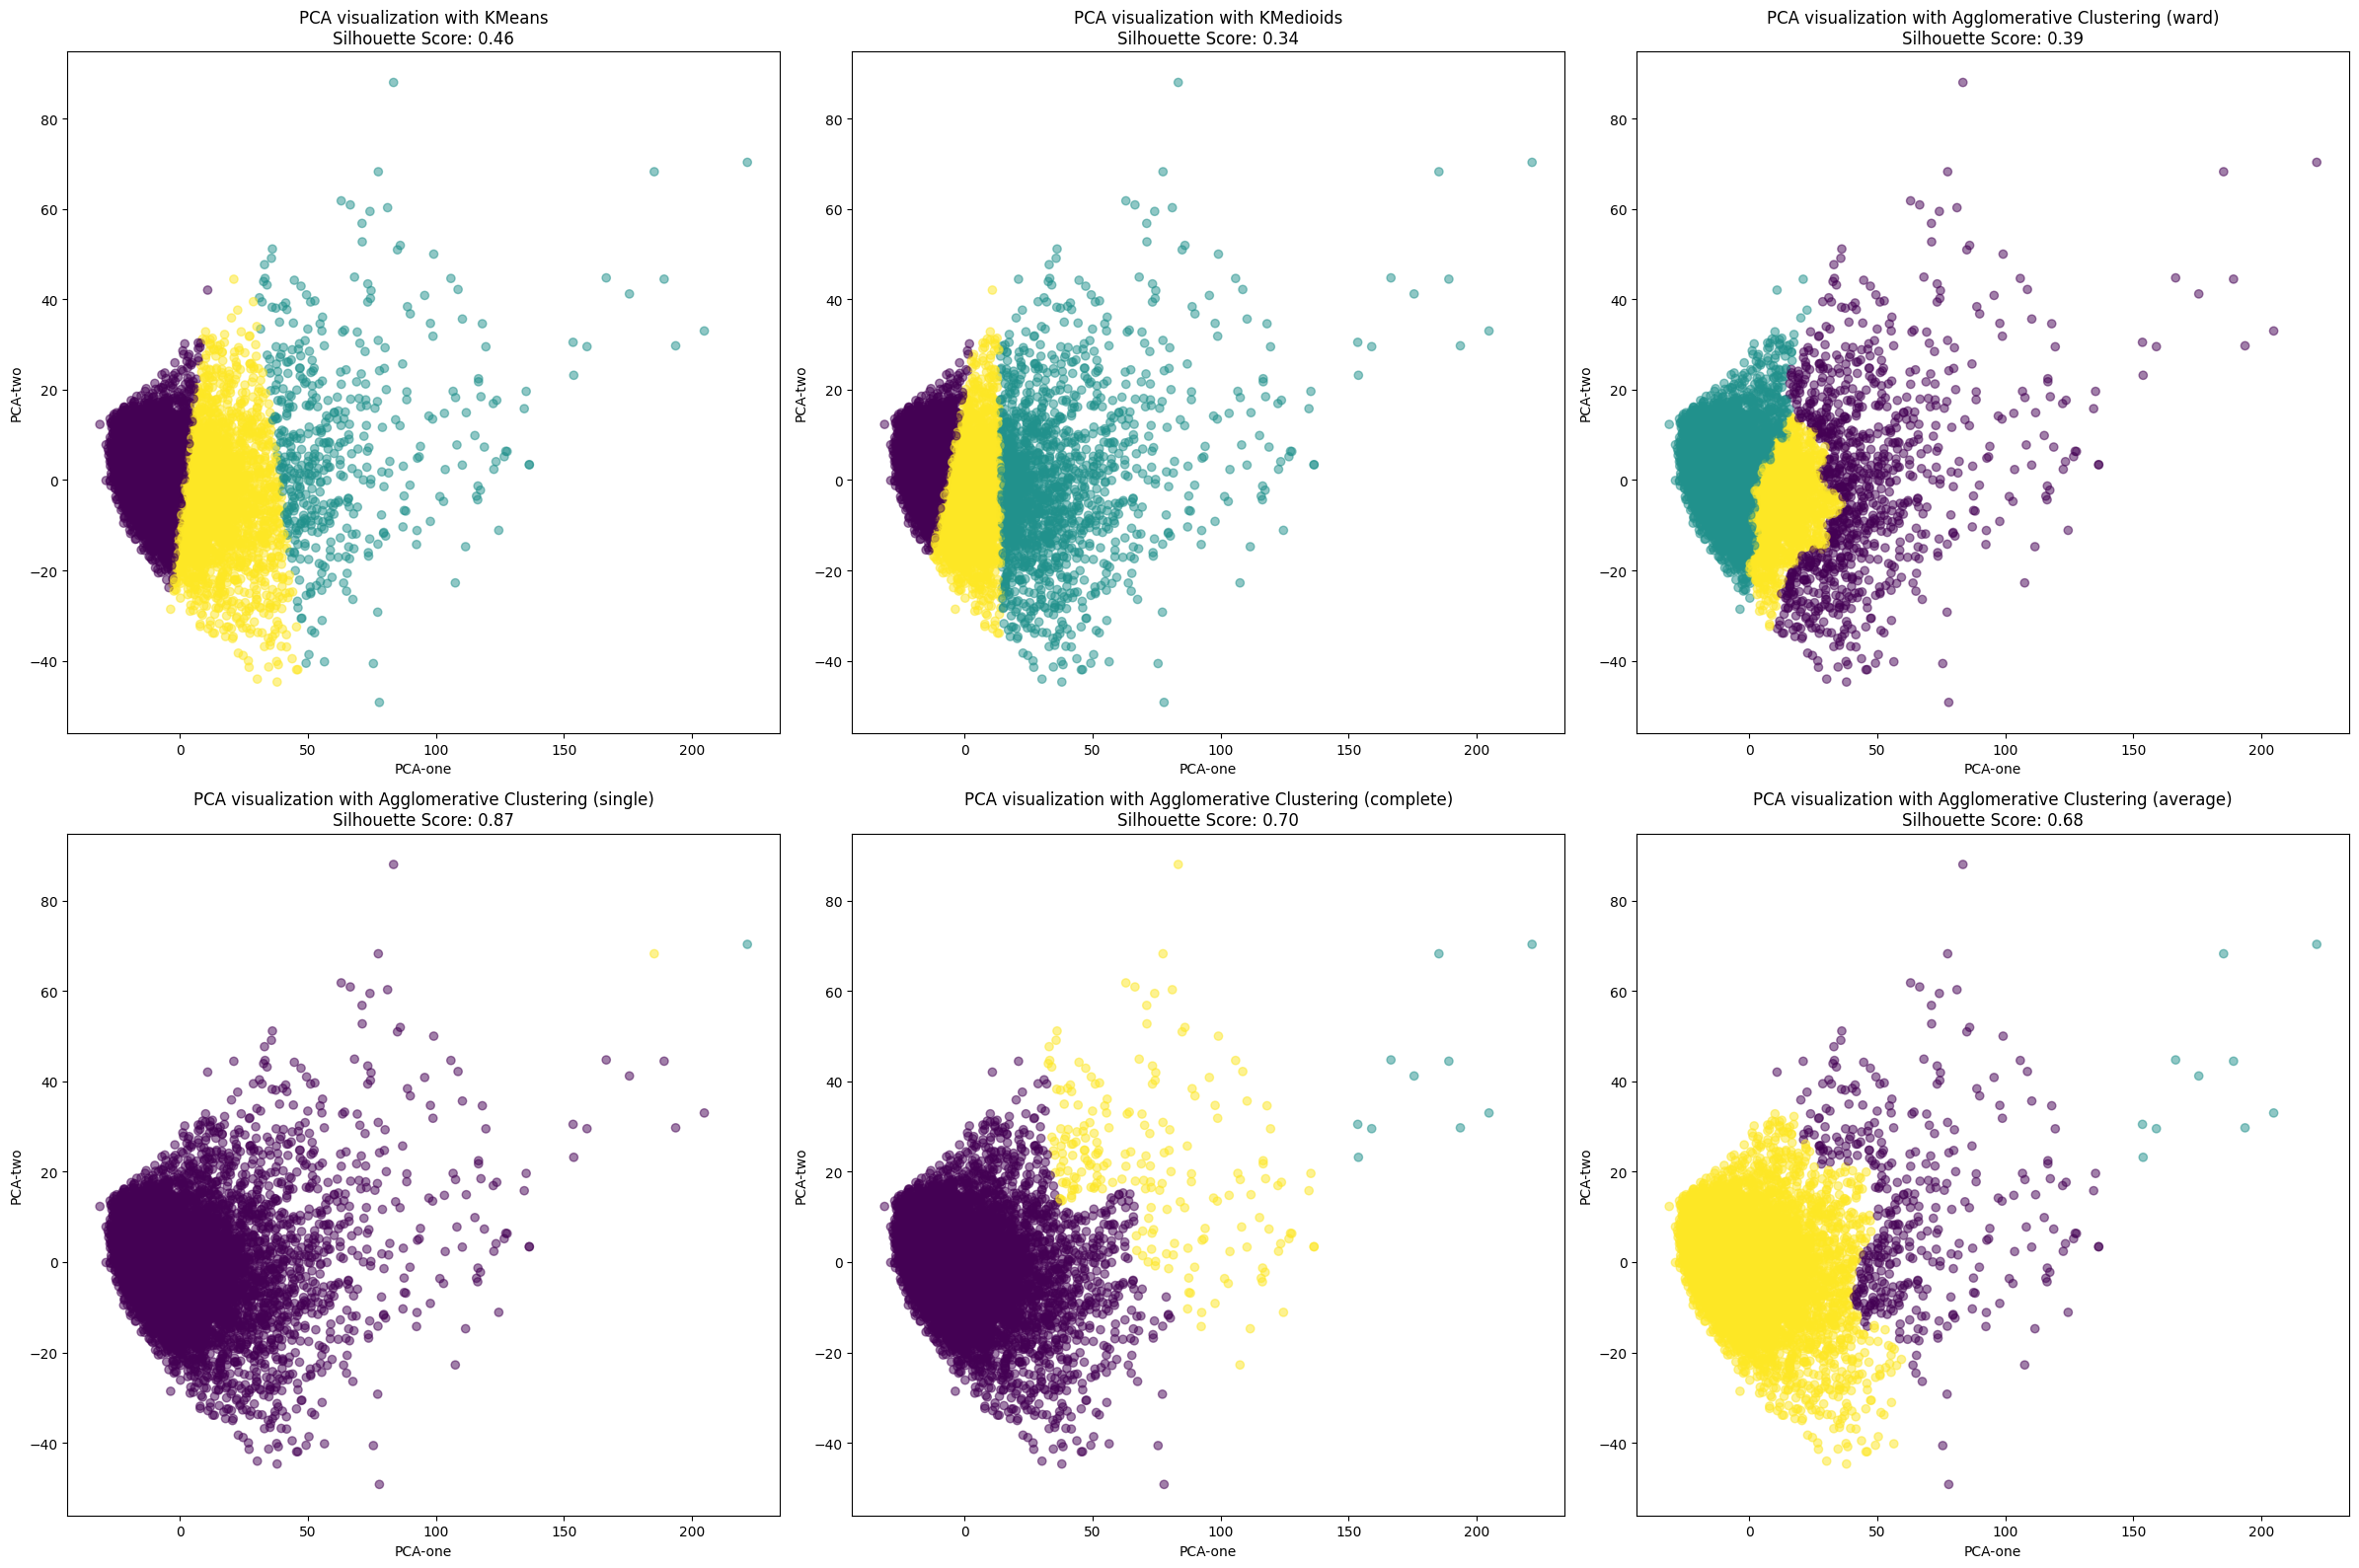

In [133]:
df = images
scaler = StandardScaler()
df = scaler.fit_transform(df)
# Performing PCA with the determined number of components
pca = PCA(n_components=2, random_state=22)
pca.fit(df)
x = pca.transform(df)
# Converting the transformed features to a DataFrame
features_df = pd.DataFrame(x)

# Adding prefixes to feature column names to avoid confusion with existing columns
features_df.columns = [f'feature_{i}' for i in range(features_df.shape[1])]

models = {
    'KMeans': KMeans,
    'KMedioids': KMedoids,
    'Agglomerative Clustering (ward)': lambda n_clusters: AgglomerativeClustering(linkage='ward', n_clusters=n_clusters),
    'Agglomerative Clustering (single)': lambda n_clusters: AgglomerativeClustering(linkage='single', n_clusters=n_clusters),
    'Agglomerative Clustering (complete)': lambda n_clusters: AgglomerativeClustering(linkage='complete', n_clusters=n_clusters),
    'Agglomerative Clustering (average)': lambda n_clusters: AgglomerativeClustering(linkage='average', n_clusters=n_clusters)
}
# Przeprowadzanie klasteryzacji i tworzenie wykresów
fig, axs = plt.subplots(2, 3, figsize=(24, 16))

for ax, (name, model) in zip(axs.flatten(), models.items()):
    labels = model(3).fit_predict(features_df)
    silhouette_avg = silhouette_score(features_df, labels)
    ax.scatter(
        x=features_df['feature_0'], 
        y=features_df['feature_1'],
        alpha=0.5,
        c=labels
    )
    ax.set_title(f'PCA visualization with {name}\nSilhouette Score: {silhouette_avg:.2f}')
    ax.set_xlabel('PCA-one')
    ax.set_ylabel('PCA-two')

plt.tight_layout()
plt.show()

Now let's try KMeans for images processed with Noise Removing Model

In [112]:
df1 = np.load('../data/After_Noise_Removal_Test.npy')
df2 = np.load('../data/After_Noise_Removal_Train.npy')
# Sample function to get random rows from a numpy array
def sample_array(arr, n, random_state=None):
    np.random.seed(random_state)
    indices = np.random.choice(arr.shape[0], n, replace=False)
    return arr[indices]

# Get 200 random rows from df1
df1_sample = sample_array(df1, 2000, random_state=42)

# Get 800 random rows from df2
df2_sample = sample_array(df2, 8000, random_state=42)

# Concatenate the sampled arrays
df = np.vstack([df1_sample, df2_sample])

df = df.reshape(10000, 28 * 28)

images = df

print(df.shape)

(10000, 784)


In [113]:
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [84]:
# Performing PCA to retain 90% of the variance
pca = PCA(random_state=22)
pca.fit(df)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

In [85]:
n_components_90

3

In [114]:
# Performing PCA with the determined number of components
pca = PCA(n_components=3, random_state=22)
pca.fit(df)
x = pca.transform(df)

In [115]:
# Converting the transformed features to a DataFrame
features_df = pd.DataFrame(x)

# Adding prefixes to feature column names to avoid confusion with existing columns
features_df.columns = [f'feature_{i}' for i in range(features_df.shape[1])]


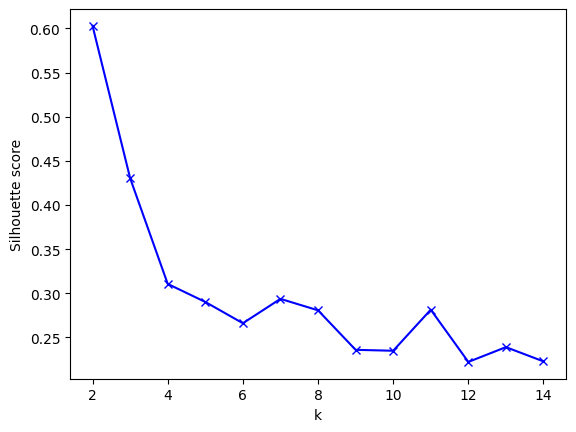

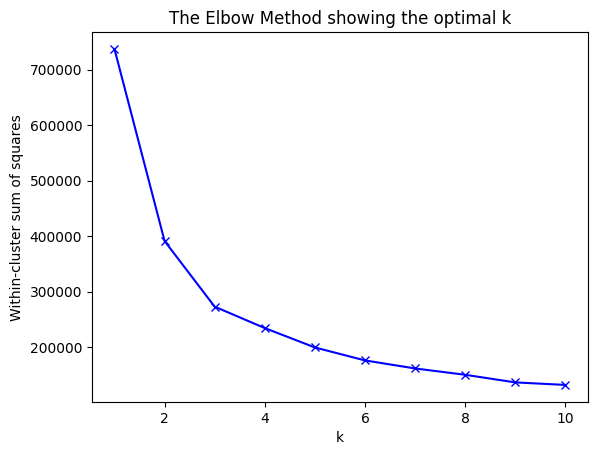

In [31]:
X = features_df
cluster_num_seq = range(2,15)
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

wcss_vec = count_wcss_scores(X, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

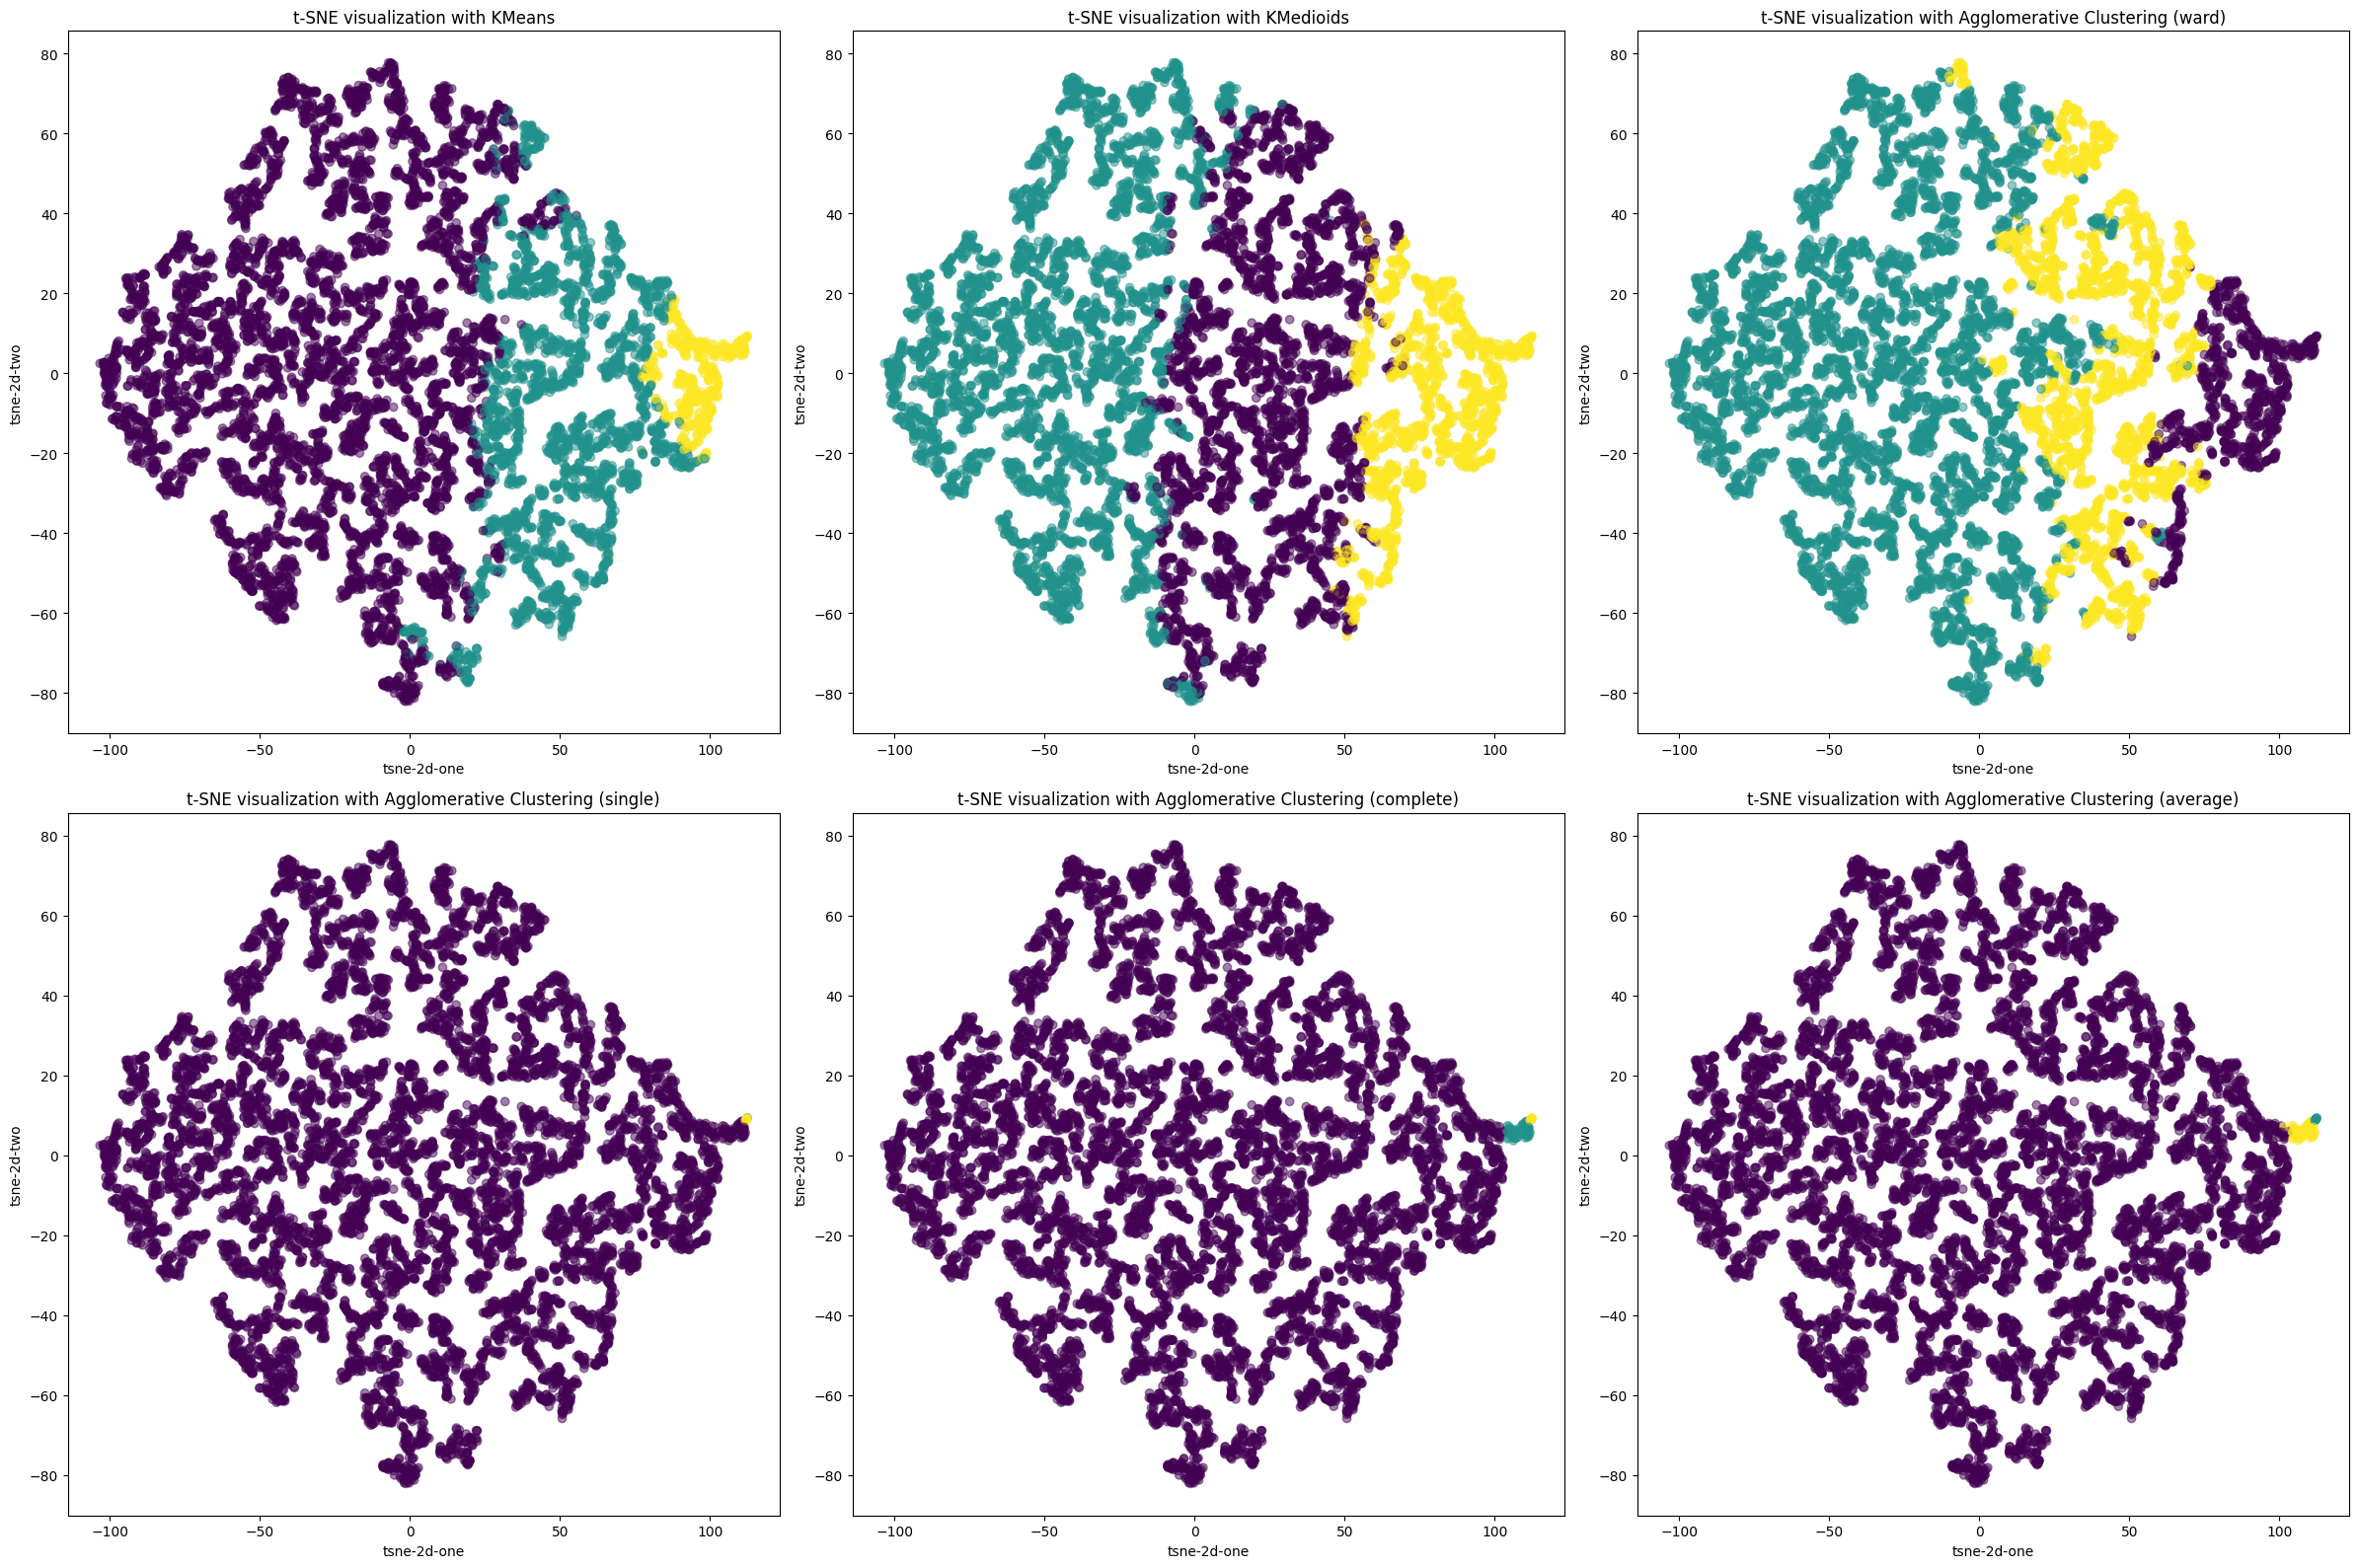

In [116]:
df = features_df

# Apply t-SNE
tsne = TSNE(n_components=2, learning_rate=200)
z = tsne.fit_transform(df)

# Add t-SNE results to the DataFrame for visualization
tsne_2d_one = z[:,0]
tsne_2d_two = z[:,1]

models = {
    'KMeans': KMeans(n_clusters=3),
    'KMedioids': KMedoids(n_clusters=3),
    'Agglomerative Clustering (ward)': AgglomerativeClustering(linkage='ward', n_clusters=3),
    'Agglomerative Clustering (single)': AgglomerativeClustering(linkage='single', n_clusters=3),
    'Agglomerative Clustering (complete)': AgglomerativeClustering(linkage='complete', n_clusters=3),
    'Agglomerative Clustering (average)': AgglomerativeClustering(linkage='average', n_clusters=3)
}

# Przeprowadzanie klasteryzacji i tworzenie wykresów
fig, axs = plt.subplots(2, 3, figsize=(24, 16))

for ax, (name, model) in zip(axs.flatten(), models.items()):
    labels = model.fit_predict(df)
    ax.scatter(
        x=tsne_2d_one, 
        y=tsne_2d_two,
        alpha=0.5,
        c=labels
    )
    ax.set_title(f't-SNE visualization with {name}')
    ax.set_xlabel('tsne-2d-one')
    ax.set_ylabel('tsne-2d-two')

plt.tight_layout()
plt.show()

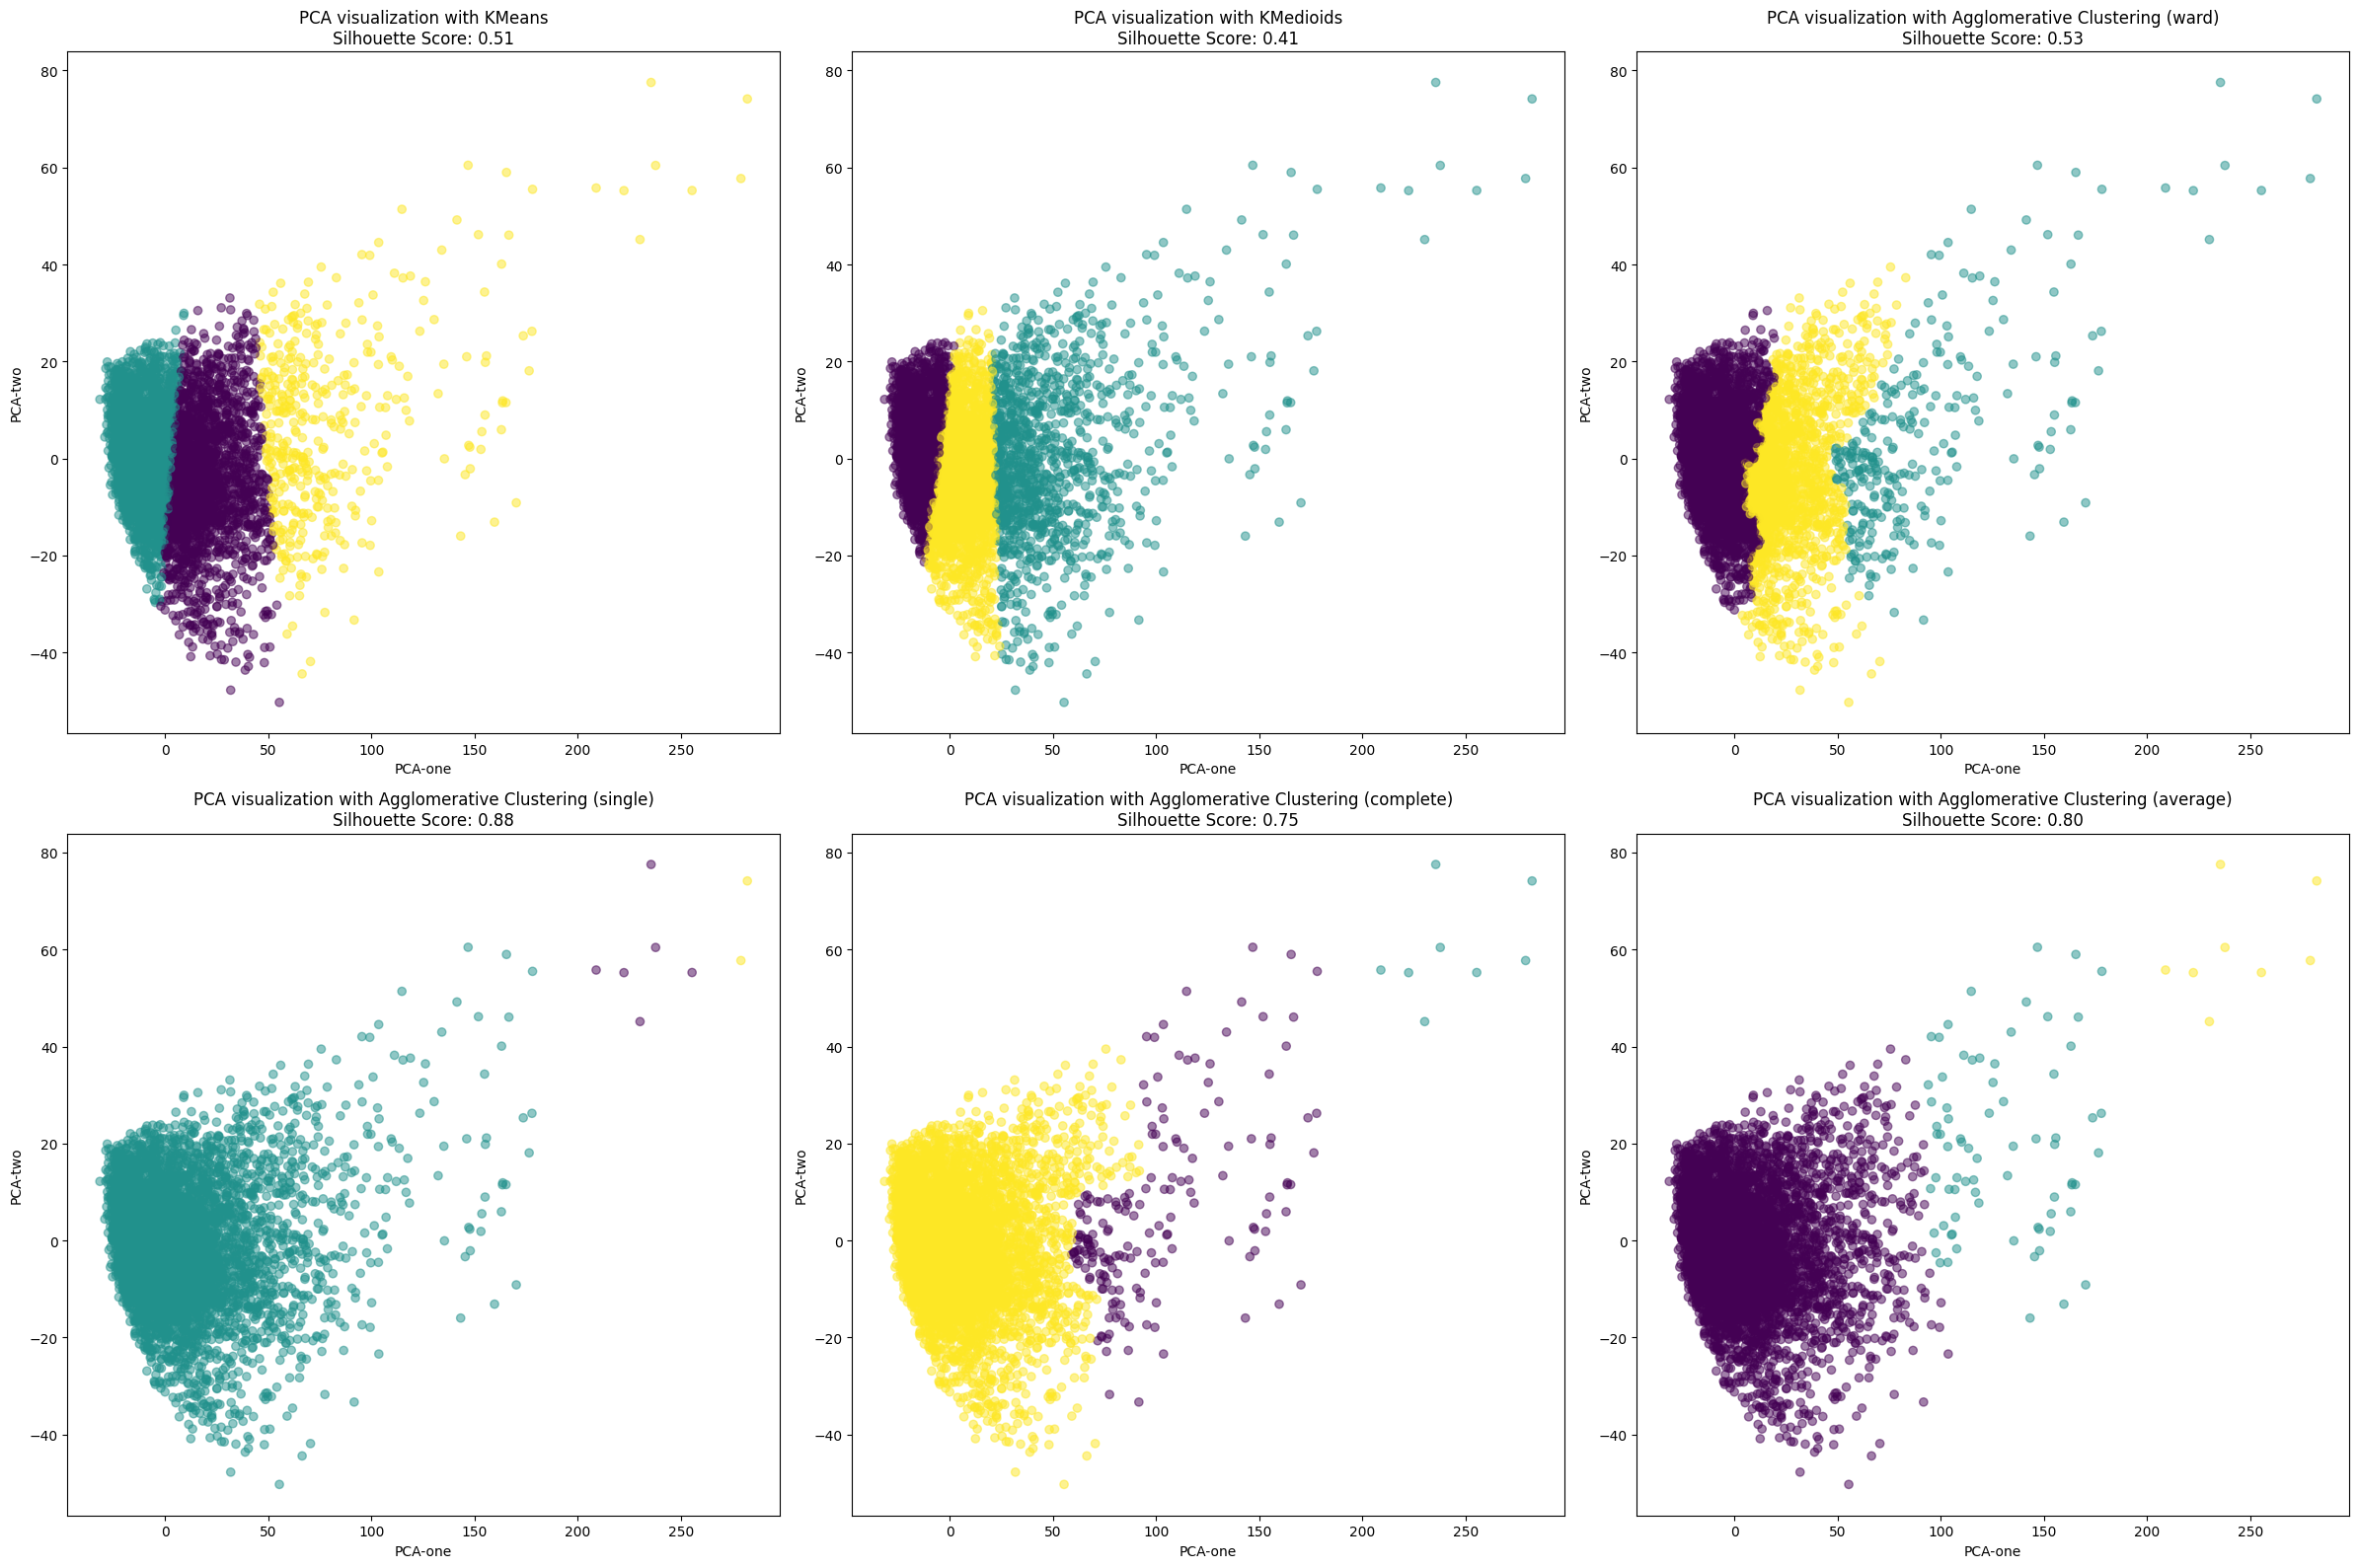

In [125]:
df = images
scaler = StandardScaler()
df = scaler.fit_transform(df)
# Performing PCA with the determined number of components
pca = PCA(n_components=2, random_state=22)
pca.fit(df)
x = pca.transform(df)
# Converting the transformed features to a DataFrame
features_df = pd.DataFrame(x)

# Adding prefixes to feature column names to avoid confusion with existing columns
features_df.columns = [f'feature_{i}' for i in range(features_df.shape[1])]

models = {
    'KMeans': KMeans,
    'KMedioids': KMedoids,
    'Agglomerative Clustering (ward)': lambda n_clusters: AgglomerativeClustering(linkage='ward', n_clusters=n_clusters),
    'Agglomerative Clustering (single)': lambda n_clusters: AgglomerativeClustering(linkage='single', n_clusters=n_clusters),
    'Agglomerative Clustering (complete)': lambda n_clusters: AgglomerativeClustering(linkage='complete', n_clusters=n_clusters),
    'Agglomerative Clustering (average)': lambda n_clusters: AgglomerativeClustering(linkage='average', n_clusters=n_clusters)
}
# Przeprowadzanie klasteryzacji i tworzenie wykresów
fig, axs = plt.subplots(2, 3, figsize=(24, 16))

for ax, (name, model) in zip(axs.flatten(), models.items()):
    labels = model(3).fit_predict(features_df)
    silhouette_avg = silhouette_score(features_df, labels)
    ax.scatter(
        x=features_df['feature_0'], 
        y=features_df['feature_1'],
        alpha=0.5,
        c=labels
    )
    ax.set_title(f'PCA visualization with {name}\nSilhouette Score: {silhouette_avg:.2f}')
    ax.set_xlabel('PCA-one')
    ax.set_ylabel('PCA-two')

plt.tight_layout()
plt.show()



In [121]:
features_df

feature_0  feature_1
0    -20.312973   3.730057
1    -21.776073   7.209433
2    -10.291660  -2.548879
3      1.560541  -5.944403
4     -7.003326   2.862008
...         ...        ...
9995 -19.589098 -10.102932
9996 -11.938686  17.363152
9997 -24.122536   0.996038
9998 -14.728790  -2.622204
9999 -16.812222   5.624771

[10000 rows x 2 columns]

This version seems to be the most promising so far. Let's look closer at these photos

In [107]:
df['cluster'] = label
sample_indices = df.groupby('cluster').apply(lambda x: x.sample(5).index).values.tolist()
sample_indices

C:\Users\Mikolaj\AppData\Local\Temp\ipykernel_17640\2062518207.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_indices = df.groupby('cluster').apply(lambda x: x.sample(5).index).values.tolist()


[Index([2140, 4724, 2566, 8013, 6469], dtype='int64'),
 Index([7110, 7218, 7782, 3300, 4198], dtype='int64'),
 Index([3349, 2372, 2116, 2409, 3788], dtype='int64')]

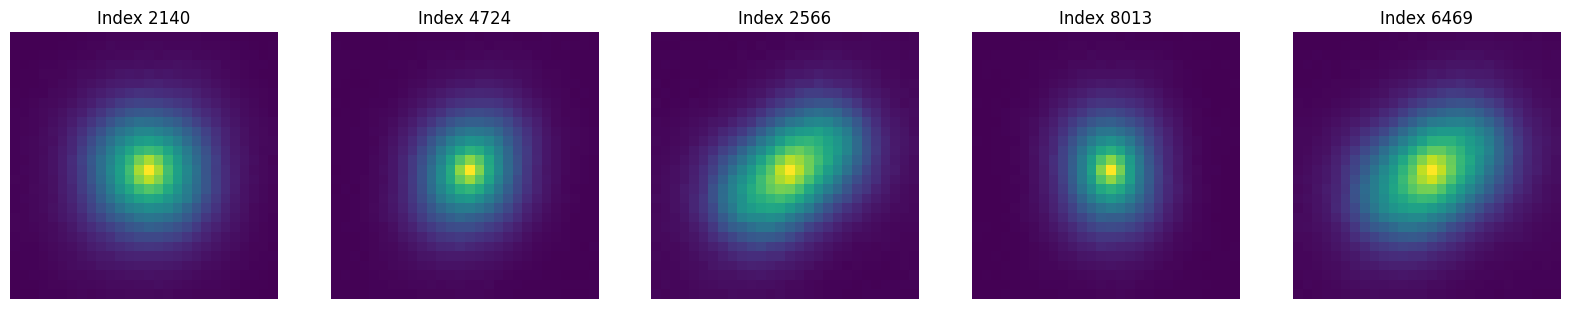

In [109]:
# Define the indices to be displayed
indices_to_display = [2140, 4724, 2566, 8013, 6469]
# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, index in zip(axes, indices_to_display):
    ax.imshow(images[index].reshape(28, 28))
    ax.set_title(f'Index {index}')
    ax.axis('off')

plt.show()


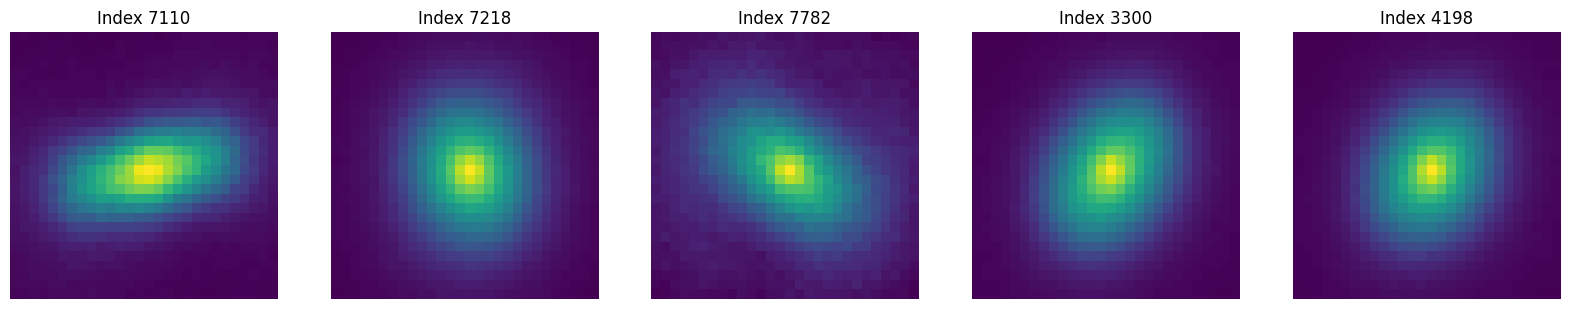

In [110]:
# Define the indices to be displayed
indices_to_display = [7110, 7218, 7782, 3300, 4198]

# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, index in zip(axes, indices_to_display):
    ax.imshow(images[index].reshape(28, 28))
    ax.set_title(f'Index {index}')
    ax.axis('off')

plt.show()

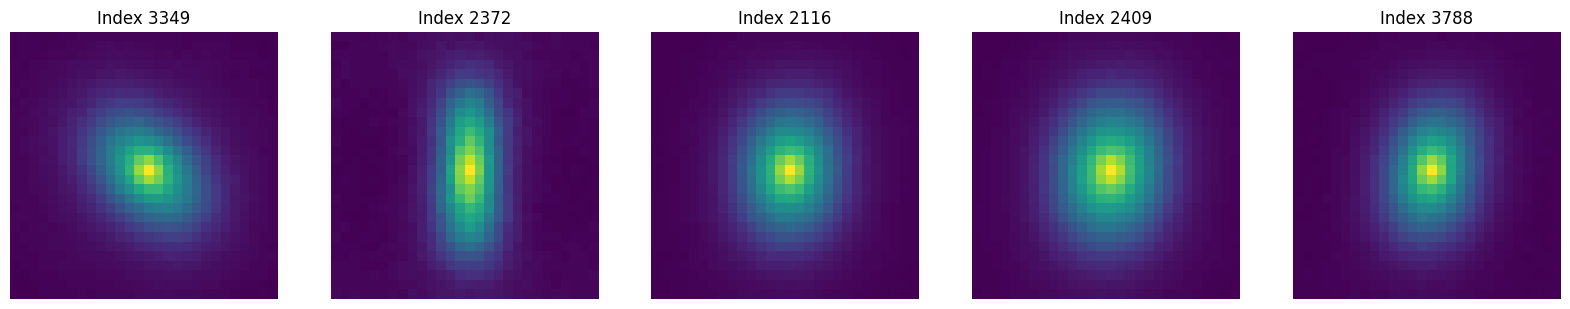

In [111]:
# Define the indices to be displayed
indices_to_display = [3349, 2372, 2116, 2409, 3788]

# Plot the images
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, index in zip(axes, indices_to_display):
    ax.imshow(images[index].reshape(28, 28))
    ax.set_title(f'Index {index}')
    ax.axis('off')

plt.show()

In [23]:
df = Removing_N_IMG.reshape(71781, 28 * 28)
normalizer = Normalizer()
df = normalizer.fit_transform(df)


NameError: name 'Removing_N_IMG' is not defined

In [52]:
scaler = StandardScaler()
df = scaler.fit_transform(df)

In [53]:
# Performing PCA to retain 90% of the variance
pca = PCA(random_state=22)
pca.fit(df)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1

In [54]:
n_components_90

4

In [55]:
# Performing PCA with the determined number of components
pca = PCA(n_components=4, random_state=22)
pca.fit(df)
x = pca.transform(df)

In [61]:

# Converting the transformed features to a DataFrame
features_df = pd.DataFrame(x)

# Adding prefixes to feature column names to avoid confusion with existing columns
features_df.columns = [f'feature_{i}' for i in range(features_df.shape[1])]

# Concatenating the original dataset with the features DataFrame
combined_df = pd.concat([feature_extracting_dataset.reset_index(drop=True), features_df.reset_index(drop=True)], axis=1)

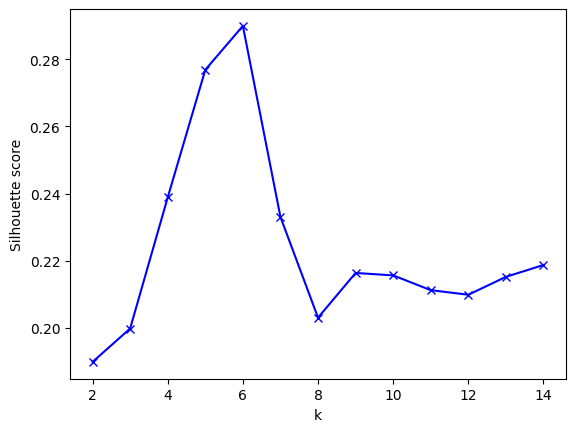

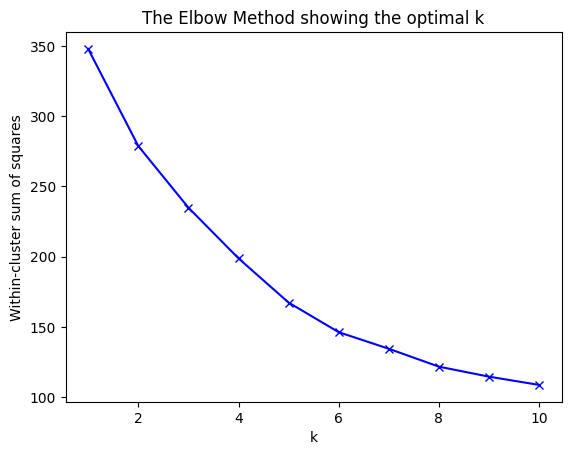

In [62]:
X = combined_df.drop(columns=['asset_id', 'image_path'])

X = X.iloc[:10000, :]

cluster_num_seq = range(2,15)
silhouette_vec = count_clustering_scores(X, cluster_num_seq, KMeans, silhouette_score)
plt.plot(cluster_num_seq, silhouette_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.show()

wcss_vec = count_wcss_scores(X, 10)
x_ticks = list(range(1, len(wcss_vec) + 1))
plt.plot(x_ticks, wcss_vec, 'bx-')
plt.xlabel('k')
plt.ylabel('Within-cluster sum of squares')
plt.title('The Elbow Method showing the optimal k')
plt.show()

C:\Users\Mikolaj\AppData\Local\Temp\ipykernel_16468\4138897928.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:,'tsne-2d-one'] = z[:,0]
C:\Users\Mikolaj\AppData\Local\Temp\ipykernel_16468\4138897928.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.loc[:,'tsne-2d-two'] = z[:,1]


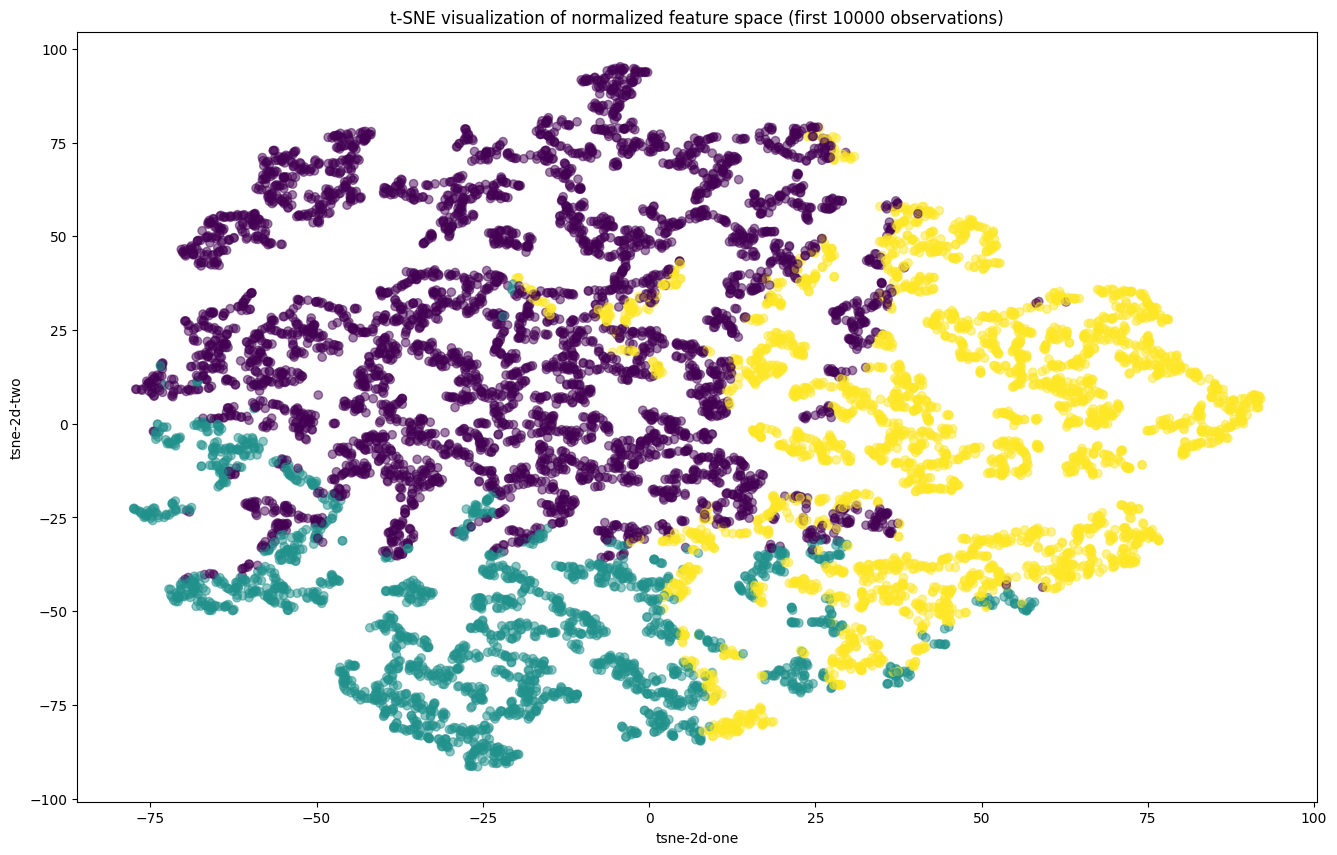

In [63]:
df = combined_df

# Select the first 10000 observations
df_subset = df.iloc[:10000, :]

# Extract feature columns
features = df_subset.iloc[:, 2:]  # Adjust if necessary to select only feature columns

# Apply t-SNE
tsne = TSNE(n_components=2, learning_rate=200)
z = tsne.fit_transform(features)

# Add t-SNE results to the DataFrame for visualization
df_subset.loc[:,'tsne-2d-one'] = z[:,0]
df_subset.loc[:,'tsne-2d-two'] = z[:,1]

model = KMeans(n_clusters = 3)
model.fit(features)
label = model.predict(features)

# Plot the result
plt.figure(figsize=(16,10))
plt.scatter(
    x=df_subset['tsne-2d-one'], 
    y=df_subset['tsne-2d-two'],
    alpha=0.5,
    c=label
)
plt.title('t-SNE visualization of normalized feature space (first 10000 observations)')
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two')
plt.show()

pd.crosstab(label, actual_labels)

In [132]:
df = np.load('../data/After_Noise_Removal_Test.npy')
df.shape


(71781, 28, 28)

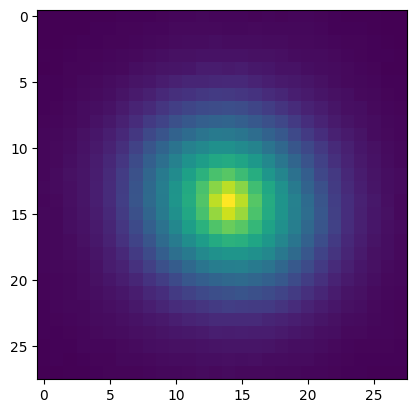

In [138]:
plt.imshow(df[1000])

In [139]:
df2 = np.load('../data/Transformated_IMG_Scaled_Test.npy')
df2.shape

(71781, 28, 28)

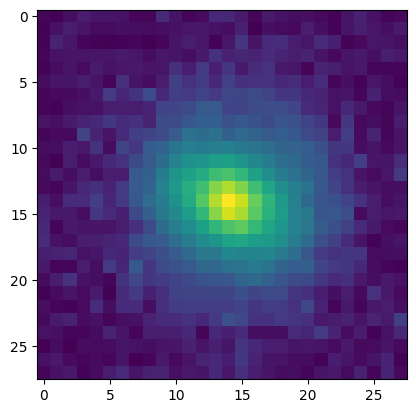

In [140]:
plt.imshow(df2[1000])

In [117]:
JPG_Path_Series = pd.read_pickle('../data/test_path_series.pkl')
JPG_Path_Series

0         ..\images_gz2\images\74543.jpg
1         ..\images_gz2\images\83338.jpg
2        ..\images_gz2\images\218082.jpg
3        ..\images_gz2\images\253795.jpg
4        ..\images_gz2\images\281244.jpg
                      ...               
71776    ..\images_gz2\images\232653.jpg
71777     ..\images_gz2\images\66841.jpg
71778    ..\images_gz2\images\248350.jpg
71779    ..\images_gz2\images\110512.jpg
71780    ..\images_gz2\images\241805.jpg
Name: path, Length: 71781, dtype: object

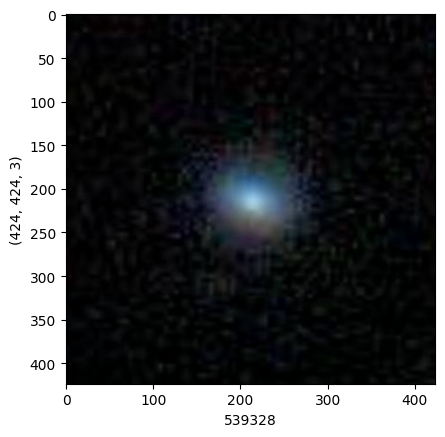

In [141]:
Example_IMG = cv2.imread(JPG_Path_Series[1000])
plt.xlabel(Example_IMG.size)
plt.ylabel(Example_IMG.shape)
plt.imshow(Example_IMG)

In [2]:
data  = pd.read_csv('../data/train_data_with_extracted_features.csv')

In [4]:
features = np.load('../data/features_array.npy')

In [6]:
reshaped = features.reshape(117240, 64, 64)

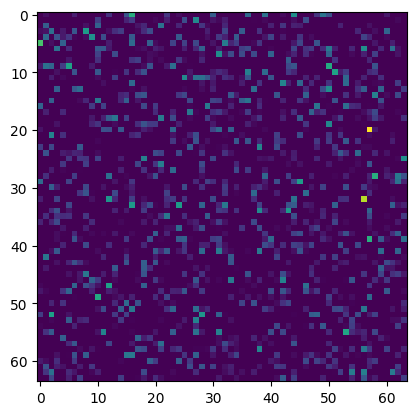

In [14]:
plt.imshow(reshaped[60])